In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import pickle5
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score   
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import folium
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor

## block warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


In [3]:
df.shape

(12711, 71)

### Remove events
The features we have constructed means that we automatically will loose some data. To use the lagged feature we need to remove the 3 first observations. In the code below we check if the sum of the 3 first life times are above 3 hours. If they are then we do not need to remove additinal variables due to the 3 hours.

In [4]:
names = df['Station_Name'].unique()

In [5]:
for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [6]:
df.shape

(12699, 71)

## Remove outliers
Use boxplot outlier definition

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Usefull functions

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [10]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    #print('MAE (Mean Absolute Error):', MAE)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    #print('MSE (Mean Squared Error):', MSE)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    #print('RMSE (Root Mean Squared Error):', RMSE)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    
    NRMSE = RMSE/np.mean(y_test)
    return MAE, RMSE, MSE, MAPE, NRMSE

### Prepare data

Add aggregated features for modeling purposes. 

In [11]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [12]:
## Add time of day and day of week
df['tod'] = df['hour_b'].apply(hour_label)

In [13]:
df = df[df['tod'] != 'Night']

Limit to 4 stations

In [14]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df_stat = df[df['Station_Name'].isin(station_subset)]

Add dummies

In [15]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','hour_b','Station_Name']
df_stat = pd.get_dummies(df_stat, columns=columns_categorical, drop_first=True)

In [16]:
## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
             'tod_Evening','tod_Midday', 'tod_Morning',
             'Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod
## M5
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management'] # dow + agg. tod + lag + activ.

Test train split

In [17]:
split = 0.8

## Quantile regression - Gradiant boosting

#### Get/split data

In [18]:
## Get X and y - M1
df_stat = df_stat.sort_values(by=['datetime_start'])
X = df_stat[features1]
y = df_stat['life_time']

## split data
X_train1, X_test1 = np.split(X, [int(split * len(X))])
y_train1, y_test1 = np.split(y, [int(split * len(X))])

In [19]:
## Get X and y - M5
X = df_stat[features5_cat+features5_con]
y = df_stat['life_time']

## split data
X_train5, X_test5 = np.split(X, [int(split * len(X))])
y_train5, y_test5 = np.split(y, [int(split * len(X))])

## Standardize
scaler = StandardScaler()
X_train5[features5_con] = scaler.fit_transform(X_train5[features5_con])
X_test5[features5_con] = scaler.transform(X_test5[features5_con])


#### Train Baseline

In [20]:
quantile_labels = ['5th','25th','50th','75th','95th']
qr_M1 = pd.DataFrame(columns=quantile_labels+['true'])
qr_M1['true'] = y_test1

Hyperparam taken from `210529-ML_4stat_singleStage_modelSelection`.

In [21]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
for i in range(len(quantiles)):
    reg = GradientBoostingRegressor(random_state=42, max_depth=2,
                                        n_estimators=500, 
                                        learning_rate=0.5,
                                        min_samples_split=2,
                                        min_samples_leaf=3,
                                        loss='quantile', alpha=quantiles[i])
    reg.fit(X_train1,y_train1)
    qr_M1[quantile_labels[i]] = reg.predict(X_test1)

#### Train Full

In [22]:
quantile_labels = ['5th','25th','50th','75th','95th']

qr_M5 = pd.DataFrame(columns=quantile_labels+['true'])
qr_M5['true'] = y_test5

In [23]:
for i in range(len(quantiles)):
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                        n_estimators=500, 
                                        learning_rate=0.01,
                                        min_samples_split=5,
                                        min_samples_leaf=5,
                                        loss='quantile', alpha=quantiles[i])
    reg.fit(X_train5,y_train5)
    qr_M5[quantile_labels[i]] = reg.predict(X_test5)

### Evaluate predictions

In [24]:
def ICP(q1, q2, true):
    if (true >= q1) and (true <= q2):
        return 1
    else:
        return 0

In [25]:
#### 5%-95%
## M1
qr_M1['MIL5-95'] = qr_M1['95th']-qr_M1['5th']
qr_M1 = qr_M1.reset_index()
# Get ICP
temp = []
for i in range(len(y_test1)):
    row = qr_M1.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
qr_M1['ICP5-95'] = temp

## M5
qr_M5['MIL5-95'] = qr_M5['95th']-qr_M5['5th']
qr_M5 = qr_M5.reset_index()
# Get ICP
temp = []
for i in range(len(y_test1)):
    row = qr_M5.loc[i]
    temp.append(ICP(row['5th'], row['95th'], row['true']))
qr_M5['ICP5-95'] = temp


#### 25%-75%
## M1
qr_M1['MIL25-75'] = qr_M1['75th']-qr_M1['25th']
# Get ICP
temp = []
for i in range(len(y_test1)):
    row = qr_M1.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
qr_M1['ICP25-75'] = temp

## M5
qr_M5['MIL25-75'] = qr_M5['75th']-qr_M5['25th']
# Get ICP
temp = []
for i in range(len(y_test1)):
    row = qr_M5.loc[i]
    temp.append(ICP(row['25th'], row['75th'], row['true']))
qr_M5['ICP25-75'] = temp


In [26]:
## merge the TOD to the dataframe
qr_M1 = qr_M1.set_index('index')
qr_M1 = qr_M1.merge(df[['tod','weekday_b_name','Station_Name']],left_index=True,right_index=True)
qr_M5 = qr_M5.set_index('index')
qr_M5 = qr_M5.merge(df[['tod','weekday_b_name','Station_Name']],left_index=True,right_index=True)

In [27]:
print("Baseline model")
for t in ['Morning', 'Midday', 'Afternoon', 'Evening']:
    res = qr_M1[qr_M1['tod'] == t]
    print("{}:\n MIL(5-95): {} ICP(5-95): {}   MIL(25-75): {} ICP(25-75): {}".format(t,round(np.mean(res['MIL5-95']),0),
                                                  round(np.mean(res['ICP5-95']),3),
                                                  round(np.mean(res['MIL25-75']),0),
                                                  round(np.mean(res['ICP25-75']),3)))

Baseline model
Morning:
 MIL(5-95): 1197.0 ICP(5-95): 0.924   MIL(25-75): 293.0 ICP(25-75): 0.455
Midday:
 MIL(5-95): 1289.0 ICP(5-95): 0.872   MIL(25-75): 375.0 ICP(25-75): 0.455
Afternoon:
 MIL(5-95): 1416.0 ICP(5-95): 0.879   MIL(25-75): 889.0 ICP(25-75): 0.49
Evening:
 MIL(5-95): 1102.0 ICP(5-95): 0.89   MIL(25-75): 298.0 ICP(25-75): 0.502


In [28]:
print("Full model")
for t in ['Morning', 'Midday', 'Afternoon', 'Evening']:
    res = qr_M5[qr_M5['tod'] == t]
    print("{}:\n MIL(5-95): {} ICP(5-95): {}   MIL(25-75): {} ICP(25-75): {}".format(t,round(np.mean(res['MIL5-95']),0),
                                                  round(np.mean(res['ICP5-95']),3),
                                                  round(np.mean(res['MIL25-75']),0),
                                                  round(np.mean(res['ICP25-75']),3)))

Full model
Morning:
 MIL(5-95): 1304.0 ICP(5-95): 0.894   MIL(25-75): 401.0 ICP(25-75): 0.508
Midday:
 MIL(5-95): 1275.0 ICP(5-95): 0.864   MIL(25-75): 385.0 ICP(25-75): 0.443
Afternoon:
 MIL(5-95): 1273.0 ICP(5-95): 0.855   MIL(25-75): 848.0 ICP(25-75): 0.434
Evening:
 MIL(5-95): 1179.0 ICP(5-95): 0.902   MIL(25-75): 315.0 ICP(25-75): 0.533


In [29]:
print("Base (5%-95%): MIL: {} ICP: {}".format(round(np.mean(qr_M1['MIL5-95']),2), 
                                            round(np.sum(qr_M1['ICP5-95'])/len(qr_M1),3)))
print("Full (5%-95%): MIL: {} ICP: {}".format(round(np.mean(qr_M5['MIL5-95']),2), 
                                            round(np.sum(qr_M5['ICP5-95'])/len(qr_M5),3)))

print("Base (25%-75%): MIL: {} ICP: {}".format(round(np.mean(qr_M1['MIL25-75']),2), 
                                            round(np.sum(qr_M1['ICP25-75'])/len(qr_M1),3)))
print("Full (25%-75%): MIL: {} ICP: {}".format(round(np.mean(qr_M5['MIL25-75']),2), 
                                            round(np.sum(qr_M5['ICP25-75'])/len(qr_M5),3)))


Base (5%-95%): MIL: 1266.32 ICP: 0.886
Full (5%-95%): MIL: 1254.14 ICP: 0.875
Base (25%-75%): MIL: 490.98 ICP: 0.477
Full (25%-75%): MIL: 501.06 ICP: 0.472


Get regression metrics for the 50th percentile

In [30]:
results = {}

In [31]:
MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(qr_M1['true'],qr_M1['50th'])
results['M1'] = {'RMSE_test':RMSE_test,'MAE_test':MAE_test,
                      'rsq_test':r2_score(qr_M1['true'],qr_M1['50th']),
                      'MAPE_test':MAPE_test,'NRMSE_test':NRMSE_test}
MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(qr_M5['true'],qr_M5['50th'])
results['M5'] = {'RMSE_test':RMSE_test,'MAE_test':MAE_test,
                      'rsq_test':r2_score(qr_M5['true'],qr_M5['50th']),
                      'MAPE_test':MAPE_test,'NRMSE_test':NRMSE_test}

In [32]:
results

{'M1': {'RMSE_test': 444.9267736319361,
  'MAE_test': 285.43539466155914,
  'rsq_test': 0.1329035784058682,
  'MAPE_test': 1165.7692972582258,
  'NRMSE_test': 0.9635878148494774},
 'M5': {'RMSE_test': 451.1913249985513,
  'MAE_test': 286.58090433277465,
  'rsq_test': 0.1083143140194136,
  'MAPE_test': 1070.2236625354722,
  'NRMSE_test': 0.9771550931525869}}

### Visualizations

Baseline

In [33]:
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night'] 

## Get mean and standard deviation of each quantile and TOD combination
results_mean = pd.DataFrame(columns=quantile_labels, index=tods)
results_std = pd.DataFrame(columns=quantile_labels, index=tods)
for t in tods:
    temp = qr_M1[qr_M1['tod'] == t]
    for q in quantile_labels:
        temp2 = temp[q]
        results_mean.loc[t][q] = np.mean(temp2.values)
        results_std.loc[t][q] = np.std(temp2.values)

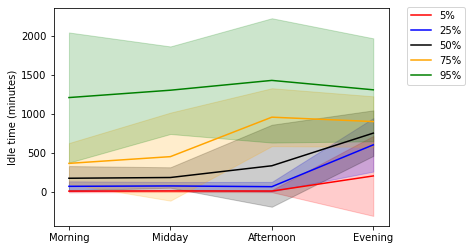

In [34]:
colors = ['red','blue','black','orange','green']
quantile_labels2 = ['5%','25%','50%','75%','95%']

for i in range(len(quantile_labels)):
    q = quantile_labels[i] # get the quantile label
   # t = tods['i'] # get the tod label
    lower = list((results_mean[q] - results_std[q]*2))
    upper = list((results_mean[q] + results_std[q]*2))
    plt.fill_between(x=tods, y1=lower, y2=upper, alpha=0.2, color=colors[i])
    plt.plot(results_mean[q], color=colors[i], label=quantile_labels2[i])
    
plt.legend(bbox_to_anchor=(1.04,1.03), loc="upper left")
plt.ylabel("Idle time (minutes)")
plt.show()

Full

In [35]:
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night'] 

## Get mean and standard deviation of each quantile and TOD combination
results_mean = pd.DataFrame(columns=quantile_labels, index=tods)
results_std = pd.DataFrame(columns=quantile_labels, index=tods)
for t in tods:
    temp = qr_M5[qr_M5['tod'] == t]
    for q in quantile_labels:
        temp2 = temp[q]
        results_mean.loc[t][q] = np.mean(temp2.values)
        results_std.loc[t][q] = np.std(temp2.values)

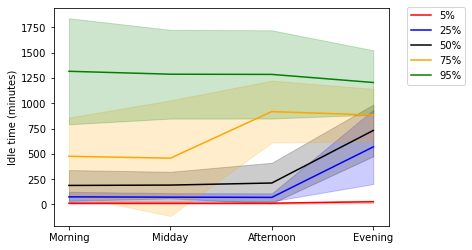

In [36]:
colors = ['red','blue','black','orange','green']

for i in range(len(quantile_labels)):
    q = quantile_labels[i] # get the quantile label
   # t = tods['i'] # get the tod label
    lower = list((results_mean[q] - results_std[q]*2))
    upper = list((results_mean[q] + results_std[q]*2))
    plt.fill_between(x=tods, y1=lower, y2=upper, alpha=0.2, color=colors[i])
    plt.plot(results_mean[q], color=colors[i], label=quantile_labels2[i])
    
plt.legend(bbox_to_anchor=(1.04,1.03), loc="upper left")
plt.ylabel("Idle time (minutes)")
plt.show()

In [37]:
import matplotlib.ticker as ticker
tick_spacing=250

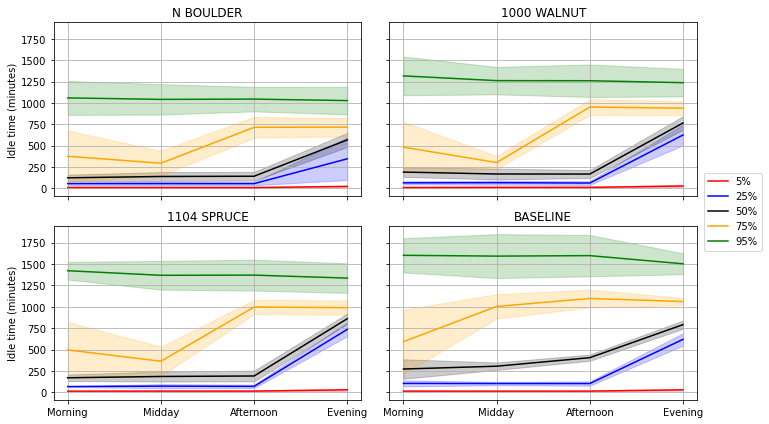

In [38]:
tods = ['Morning','Midday','Afternoon','Evening']
stat_names = ['N BOULDER', '1000 WALNUT', '1104 SPRUCE', 'BASELINE']

fig, axs = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)
m = 0
n = 0

for i in range(len(station_subset)):
    stat = station_subset[i]
    temp = qr_M5[qr_M5['Station_Name'] == stat]
    
    ## Get mean and standard deviation of each quantile and TOD combination
    results_mean = pd.DataFrame(columns=quantile_labels, index=tods)
    results_std = pd.DataFrame(columns=quantile_labels, index=tods)
    for t in tods:
        temp2 = temp[temp['tod'] == t]
        for q in quantile_labels:
            temp3 = temp2[q]
            results_mean.loc[t][q] = np.mean(temp3.values)
            results_std.loc[t][q] = np.std(temp3.values)
            
    colors = ['red','blue','black','orange','green']

    for j in range(len(quantile_labels)):
        q = quantile_labels[j] # get the quantile label
        lower = list((results_mean[q] - results_std[q]*2))
        upper = list((results_mean[q] + results_std[q]*2))
        axs[m,n].fill_between(x=tods, y1=lower, y2=upper, alpha=0.2, color=colors[j])
        axs[m,n].plot(results_mean[q], color=colors[j], label=quantile_labels2[j])
        axs[m,n].set_title(stat_names[i])
        axs[m,n].grid()
        axs[m,n].yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
                              
    n += 1
    if n == 2:
        n = 0
        m = 1

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.07,0.50), loc='center right')
axs[0,0].set_ylabel("Idle time (minutes)")
axs[1,0].set_ylabel("Idle time (minutes)")
plt.tight_layout()
plt.savefig('../visualization/QR_TOD_stat.pdf',bbox_inches='tight')
plt.show()

### See most important features

In [39]:
q1 = 0.05
q2 = 0.25
q3 = 0.50
q4 = 0.75
q5 = 0.95
reg1 = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=500, 
                                    learning_rate=0.01,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    loss='quantile', alpha=q1)
reg1.fit(X_train5,y_train5)
important1 = reg1.feature_importances_

reg2 = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=500, 
                                    learning_rate=0.01,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    loss='quantile', alpha=q2)
reg2.fit(X_train5,y_train5)
important2 = reg2.feature_importances_

reg3 = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=500, 
                                    learning_rate=0.01,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    loss='quantile', alpha=q3)
reg3.fit(X_train5,y_train5)
important3 = reg3.feature_importances_

reg4 = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=500, 
                                    learning_rate=0.01,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    loss='quantile', alpha=q4)
reg4.fit(X_train5,y_train5)
important4 = reg4.feature_importances_

reg5 = GradientBoostingRegressor(random_state=42, max_depth=3,
                                    n_estimators=500, 
                                    learning_rate=0.01,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    loss='quantile', alpha=q5)
reg5.fit(X_train5,y_train5)
important5 = reg5.feature_importances_
cols = X_train5.columns

The importance of different features for the 25% quantile and the 95% quantile.

In [40]:
imp1 = pd.DataFrame(columns=['fea','importance'])
imp1['fea'] = cols
imp1['importance'] = important1
imp1 = imp1.sort_values(by=['importance'], ascending=False)

imp2 = pd.DataFrame(columns=['fea','importance'])
imp2['fea'] = cols
imp2['importance'] = important2
imp2 = imp2.sort_values(by=['importance'],ascending=False)

imp3 = pd.DataFrame(columns=['fea','importance'])
imp3['fea'] = cols
imp3['importance'] = important3
imp3 = imp3.sort_values(by=['importance'],ascending=False)

imp4 = pd.DataFrame(columns=['fea','importance'])
imp4['fea'] = cols
imp4['importance'] = important4
imp4 = imp4.sort_values(by=['importance'],ascending=False)

imp5 = pd.DataFrame(columns=['fea','importance'])
imp5['fea'] = cols
imp5['importance'] = important5
imp5 = imp5.sort_values(by=['importance'],ascending=False)

In [41]:
print("5th quantile")
print(imp1.head(7))
print("\n25th quantile")
print(imp2.head(7))
print("\n50th quantile")
print(imp3.head(7))
print("\n75th quantile")
print(imp4.head(7))
print("\n95th quantile")
print(imp5.head(7))

5th quantile
                      fea  importance
17         charge_time_4H    0.505800
13                   lag2    0.114747
7              tod_Midday    0.105075
14                   lag3    0.083704
18       charge_energy_4H    0.081019
12                   lag1    0.027428
16  near_charge_energy_4H    0.019532

25th quantile
                 fea  importance
6        tod_Evening    0.543888
13              lag2    0.075313
14              lag3    0.066248
17    charge_time_4H    0.061278
18  charge_energy_4H    0.046447
23           medical    0.036909
26  waste-management    0.024170

50th quantile
                 fea  importance
6        tod_Evening    0.752927
14              lag3    0.031783
13              lag2    0.022727
17    charge_time_4H    0.022214
23           medical    0.021681
26  waste-management    0.016641
12              lag1    0.016596

75th quantile
               fea  importance
7       tod_Midday    0.231280
8      tod_Morning    0.212795
13            lag